# Miniproyecto #2: Extracción de características


**Autores:**
*   Jorge Sebastián Arroyo Estrada CC. 1193482707
*   César Augusto Montoya Ocampo CC. 1036681523

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

---

## Librerías

In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage as skim

%matplotlib inline

## Globales

In [2]:
# Tenemos varias opciones para la base de datos
DB_PATH128 = Path("../01_preprocessing/preprocessed_db128/")
DB_PATH64 = Path("../01_preprocessing/preprocessed_db64/")

In [3]:
def read_image(image_path: Path) -> np.ndarray:
    """Lee una imagen desde la ruta dada y devuelve un array de numpy."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"La imagen con ruta {image_path} no se pudo leer.")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def show_image(image, title, ax):
    if image.shape[-1] != 3:
        ax.imshow(image, cmap="gray")
    else:
        ax.imshow(image)
    ax.axis("off")
    ax.set_title(title)


def show_hist(hist, bins, hist_range, title, ax):
    ax.set_xlabel(f"Valor {title}")
    ax.set_ylabel("Frequency")
    ax.bar(np.linspace(*hist_range, len(hist)), hist)
    ax.set_xlim(hist_range)
    ax.set_title(f"Histograma {title}")

# Extracción de características

In [4]:
def get_hog(img, hog_params):
    return skim.feature.hog(img, **hog_params)


def get_lbp(img, lbp_params):
    lbp = skim.feature.local_binary_pattern(
        cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), **lbp_params
    )

    lbp_hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, lbp_params["P"] + 3),
        range=(0, lbp_params["P"] + 2),
        density=True,
    )
    return lbp, lbp_hist


def compute_channel_histogram(
    channel: np.ndarray, bins: int, hist_range: tuple
) -> np.ndarray:
    hist = cv2.calcHist([channel], [0], None, [bins], hist_range)
    return cv2.normalize(hist, hist).flatten()


def get_hsv_color_histograms(
    image: np.ndarray, hsv_hist_params, plot: bool = False, axes=None
) -> np.ndarray:
    # Extraer el parámetro bins o asignarlo por defecto
    bins = hsv_hist_params.get("bins", 50)

    # Convertir espacios de color
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Definir los rangos posibles para cada canal
    hist_params = [
        (hsv_image[:, :, 0], bins, (0, 180), "H"),  # Hue: rango [0, 180]
        (hsv_image[:, :, 1], bins, (0, 256), "S"),  # Saturation: rango [0, 256]
        (hsv_image[:, :, 2], bins, (0, 256), "V"),  # Value: rango [0, 256]
    ]

    # Computar y apilar los histogramas para cada canal
    hsv_features = []
    for i, (channel, b, hist_range, name) in enumerate(hist_params):
        hist = compute_channel_histogram(channel, b, hist_range)
        hsv_features.append(hist)
        if plot:
            show_hist(hist, b, hist_range, name, axes[i])

    return np.hstack(hsv_features)


def extract_features(db_path: Path, hog_params, lbp_params, hsv_hist_params):
    features = []
    labels = {}
    n = 0

    for tag, fruit_tag in enumerate(db_path.iterdir(), start=1):
        if not fruit_tag.is_dir():
            continue

        print(f"Label {tag} assigned to {fruit_tag.name} class")
        labels[tag] = fruit_tag.name

        for image_path in fruit_tag.iterdir():
            if image_path.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                # Read image
                img = read_image(image_path)

                # HOG
                fd = get_hog(img, hog_params)

                # LBP
                lbp, lbp_hist = get_lbp(img, lbp_params)

                # HSV histogram
                hsv_feats = get_hsv_color_histograms(img, hsv_hist_params)

                # Display the number of features for the first image
                if n == 0:
                    hog_n = fd.ravel().size
                    lbp_n = lbp_hist.size
                    hsv_n = hsv_feats.size
                    print(f"Number of HOG features: {hog_n}")
                    print(f"Number of LBP histogram features: {lbp_n}")
                    print(f"Number of HSV histogram features: {hsv_n}")

                # Combine features into a vector
                feature_col = np.hstack((fd.ravel(), lbp_hist, hsv_feats, [tag]))
                features.append(feature_col)
                n += 1
            else:
                print(f"Ignoring file due to invalid extension: {image_path}")

    # Transform into dataframe
    features_df = pd.DataFrame(features)
    features_df.columns = (
        [f"hog_{i}" for i in range(1, hog_n + 1)]
        + [f"lbp_{i}" for i in range(1, lbp_n + 1)]
        + [f"hsv_{i}" for i in range(1, hsv_n + 1)]
        + ["label"]
    )
    labels_df = pd.DataFrame.from_dict(labels, orient="index", columns=["label"])
    return features_df, labels_df


def visualize_features(img, hog_params, lbp_params, hsv_hist_params):
    # HOG
    fd, hog_image = get_hog(img, hog_params)

    # LBP
    lbp, lbp_hist = get_lbp(img, lbp_params)

    # Gráficas
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), layout="tight")
    ax = axes.ravel()

    # Imagen original
    show_image(img, "Imagen original", ax[0])

    # HOG
    show_image(hog_image, "HOG", ax[1])

    # LBP
    show_image(lbp, "LBP", ax[2])

    # Histograma HSV
    hsv_feats = get_hsv_color_histograms(img, hsv_hist_params, plot=True, axes=ax[3:])

    plt.show()

# Para imágenes de 128×128

In [5]:
# Acá se selecciona con cuál se va a trabajar
DB_PATH = DB_PATH128

HOG_PARAMS = {
    "orientations": 8,
    "pixels_per_cell": (16, 16),
    "cells_per_block": (2, 2),
    "visualize": False,
    "channel_axis": -1,
}

radius = 3
LBP_PARAMS = {"R": radius, "P": 8 * radius, "method": "uniform"}
HSV_HIST_PARAMS = {"bins": 50}

features, labels = extract_features(DB_PATH, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

Label 1 assigned to fresh_apple class
Number of HOG features: 1568
Number of LBP histogram features: 26
Number of HSV histogram features: 150
Label 2 assigned to fresh_banana class
Label 3 assigned to fresh_orange class
Label 4 assigned to fresh_tomato class
Label 5 assigned to stale_apple class
Label 6 assigned to stale_banana class
Label 7 assigned to stale_orange class
Label 8 assigned to stale_tomato class


In [6]:
DF_PATH = Path("./features_128.csv")
LABELS_PATH = Path("./labels.csv")

features.to_csv(DF_PATH)
labels.to_csv(LABELS_PATH, index_label="Class")

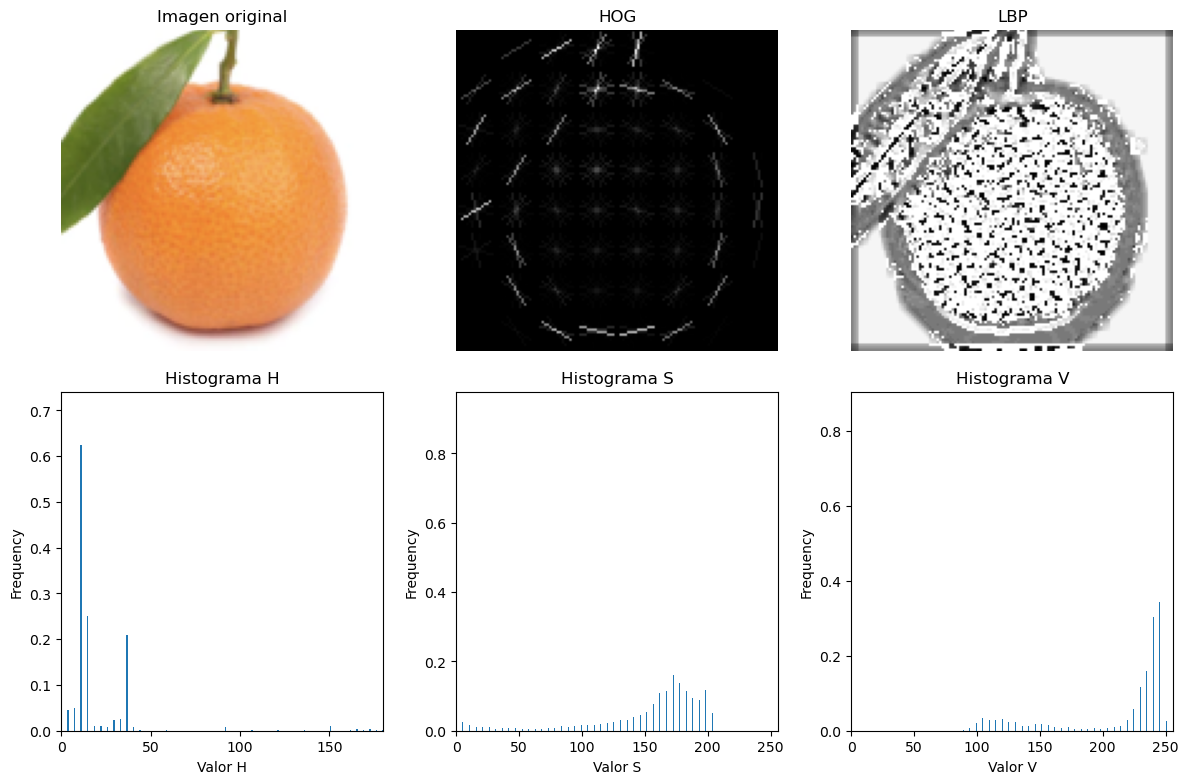

In [7]:
HOG_PARAMS = {
    "orientations": 8,
    "pixels_per_cell": (16, 16),
    "cells_per_block": (2, 2),
    "visualize": True,
    "channel_axis": -1,
}

radius = 3
LBP_PARAMS = {"R": radius, "P": 8 * radius, "method": "uniform"}

HSV_HIST_PARAMS = {"bins": 50}

# Naranja fresca
img = read_image(DB_PATH / "fresh_orange/Screen Shot 2018-06-13 at 12.00.17 AM.png")

# Habilitar la graficación del HOG
visualize_features(img, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

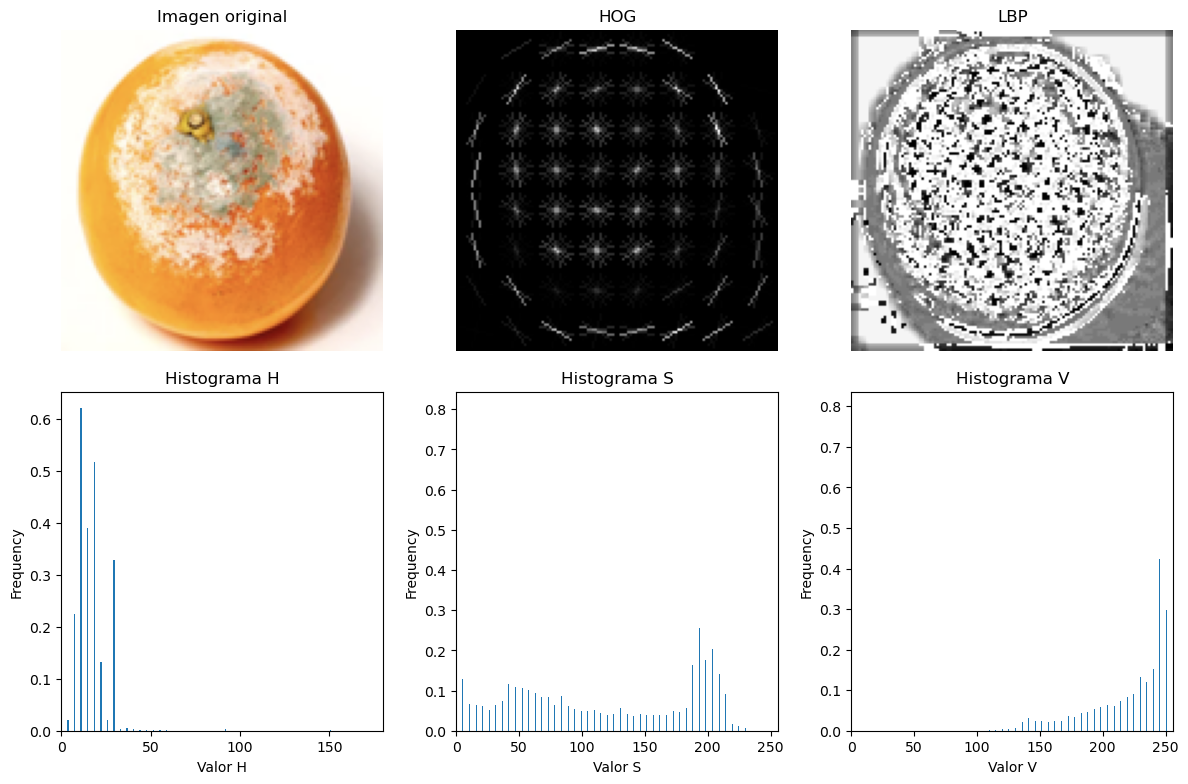

In [8]:
# Naranja pútrida´
img = read_image(DB_PATH / "stale_orange/Screen Shot 2018-06-12 at 11.39.29 PM.png")

# Habilitar la graficación del HOG
visualize_features(img, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

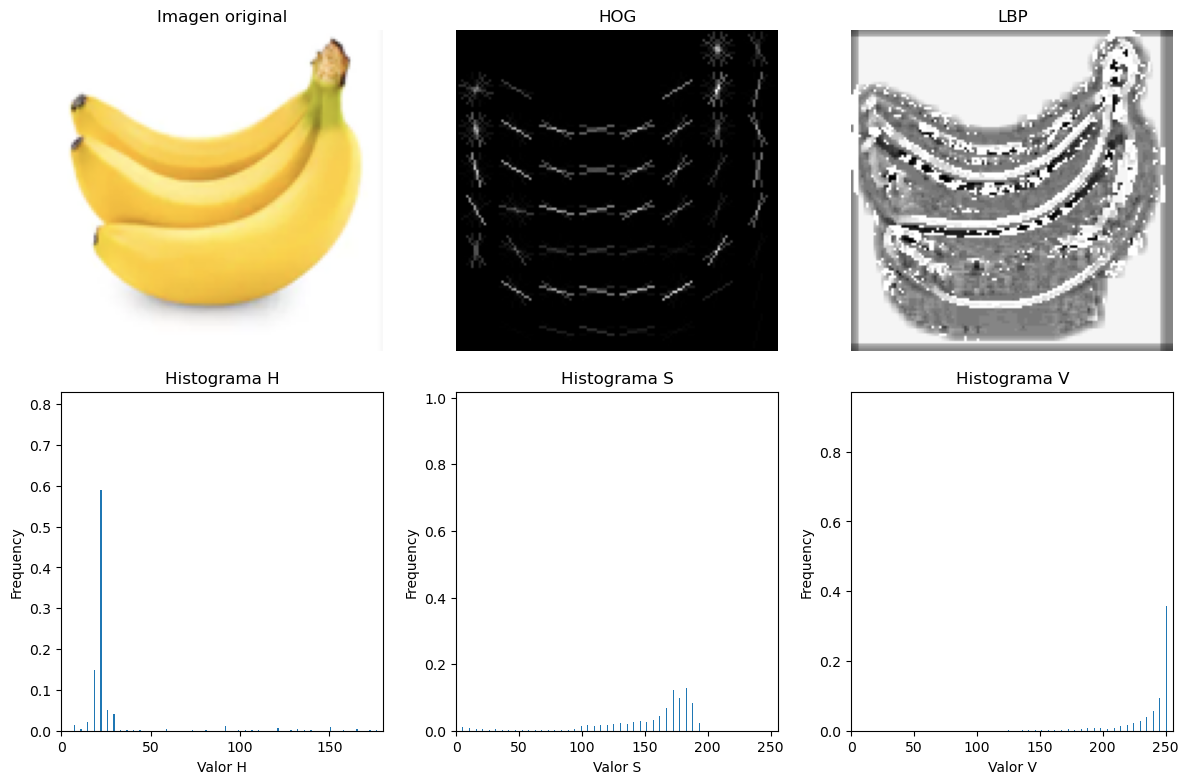

In [9]:
# Banana fresca
img = read_image(DB_PATH / "fresh_banana/Screen Shot 2018-06-12 at 9.48.39 PM.png")

# Habilitar la graficación del HOG
visualize_features(img, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

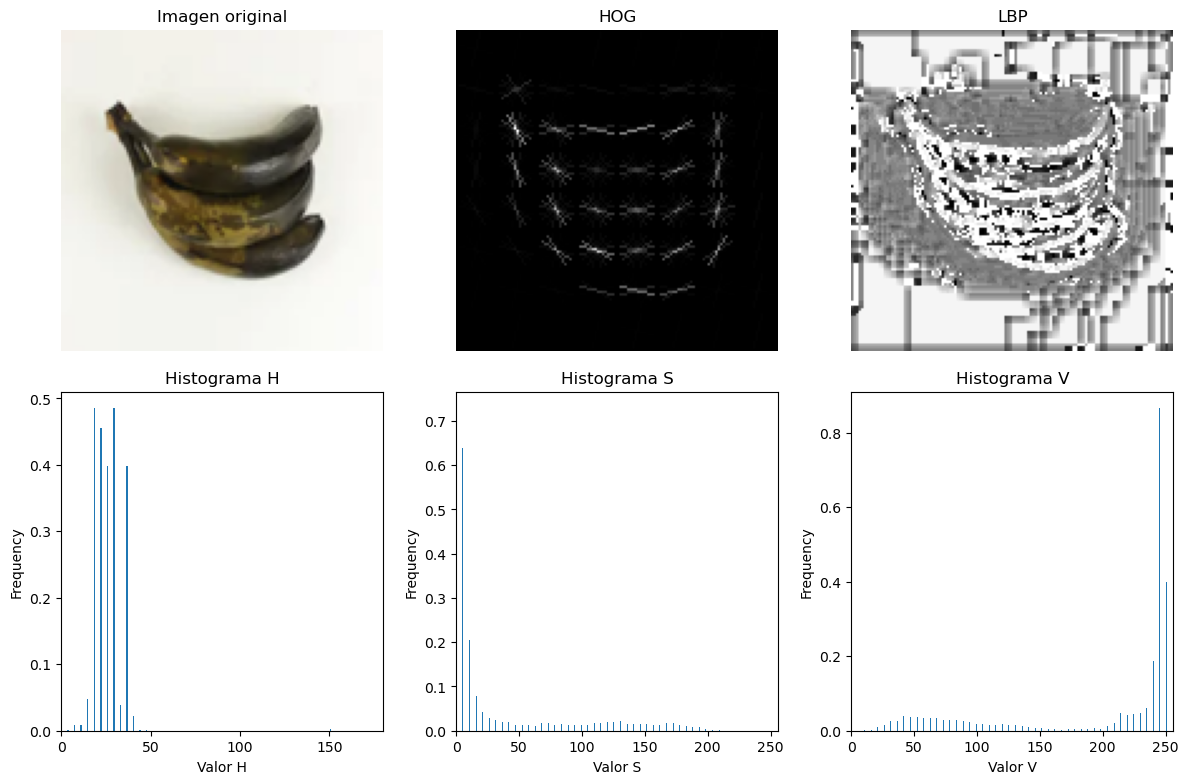

In [10]:
# Banana pútrida
img = read_image(DB_PATH / "stale_banana/Screen Shot 2018-06-12 at 8.58.49 PM.png")

# Habilitar la graficación del HOG
visualize_features(img, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

# Para imágenes de 64×64

In [11]:
# Acá se selecciona con cuál se va a trabajar
DB_PATH = DB_PATH64

HOG_PARAMS = {
    "orientations": 8,
    "pixels_per_cell": (16, 16),
    "cells_per_block": (2, 2),
    "visualize": False,
    "channel_axis": -1,
}

radius = 3
LBP_PARAMS = {"R": radius, "P": 8 * radius, "method": "uniform"}

HSV_HIST_PARAMS = {"bins": 50}

# Se extraen nuevamente las características para las imágenes de 64×64
# Sin embargo, las etiquetas son las mismas, por lo ques se omiten
features, _ = extract_features(DB_PATH, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

Label 1 assigned to fresh_apple class
Number of HOG features: 288
Number of LBP histogram features: 26
Number of HSV histogram features: 150
Label 2 assigned to fresh_banana class
Label 3 assigned to fresh_orange class
Label 4 assigned to fresh_tomato class
Label 5 assigned to stale_apple class
Label 6 assigned to stale_banana class
Label 7 assigned to stale_orange class
Label 8 assigned to stale_tomato class


In [12]:
DF_PATH = Path("./features_64.csv")

features.to_csv(DF_PATH)

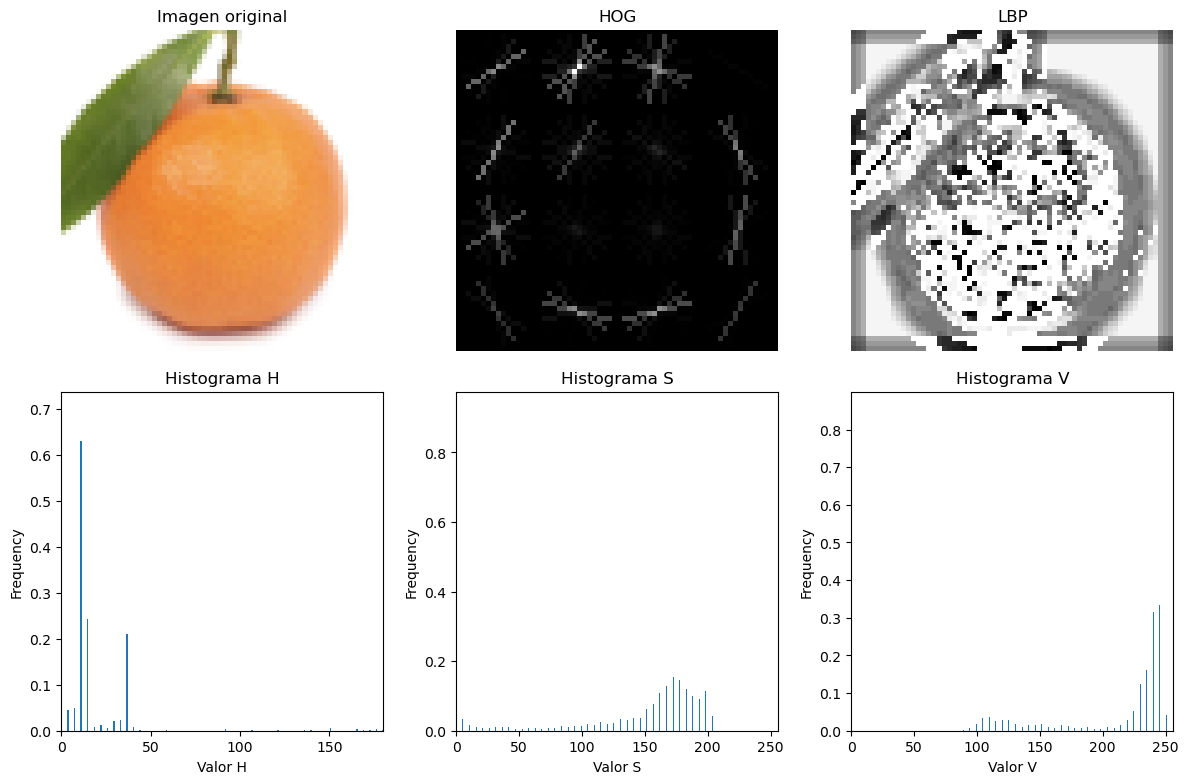

In [13]:
HOG_PARAMS = {
    "orientations": 8,
    "pixels_per_cell": (16, 16),
    "cells_per_block": (2, 2),
    "visualize": True,
    "channel_axis": -1,
}

# Naranja fresca
img = read_image(DB_PATH / "fresh_orange/Screen Shot 2018-06-13 at 12.00.17 AM.png")

# Habilitar la graficación del HOG
visualize_features(img, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

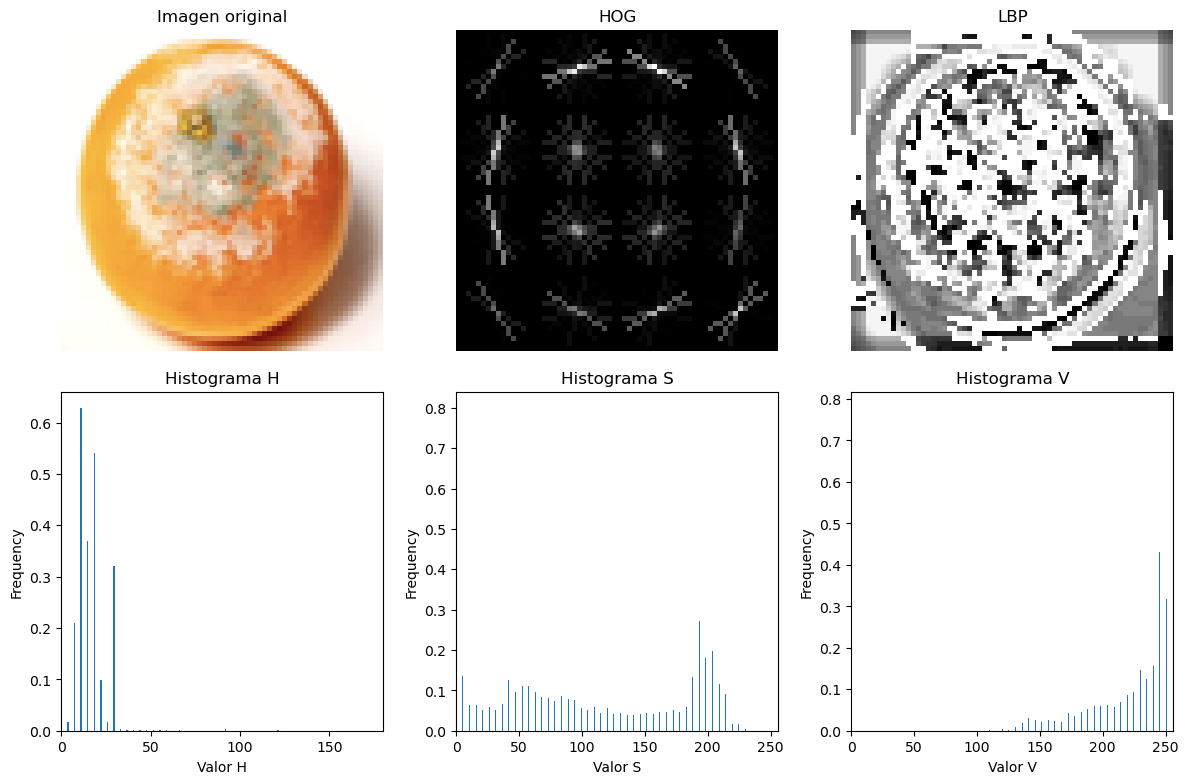

In [14]:
# Naranja pútrida´
img = read_image(DB_PATH / "stale_orange/Screen Shot 2018-06-12 at 11.39.29 PM.png")

# Habilitar la graficación del HOG
visualize_features(img, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

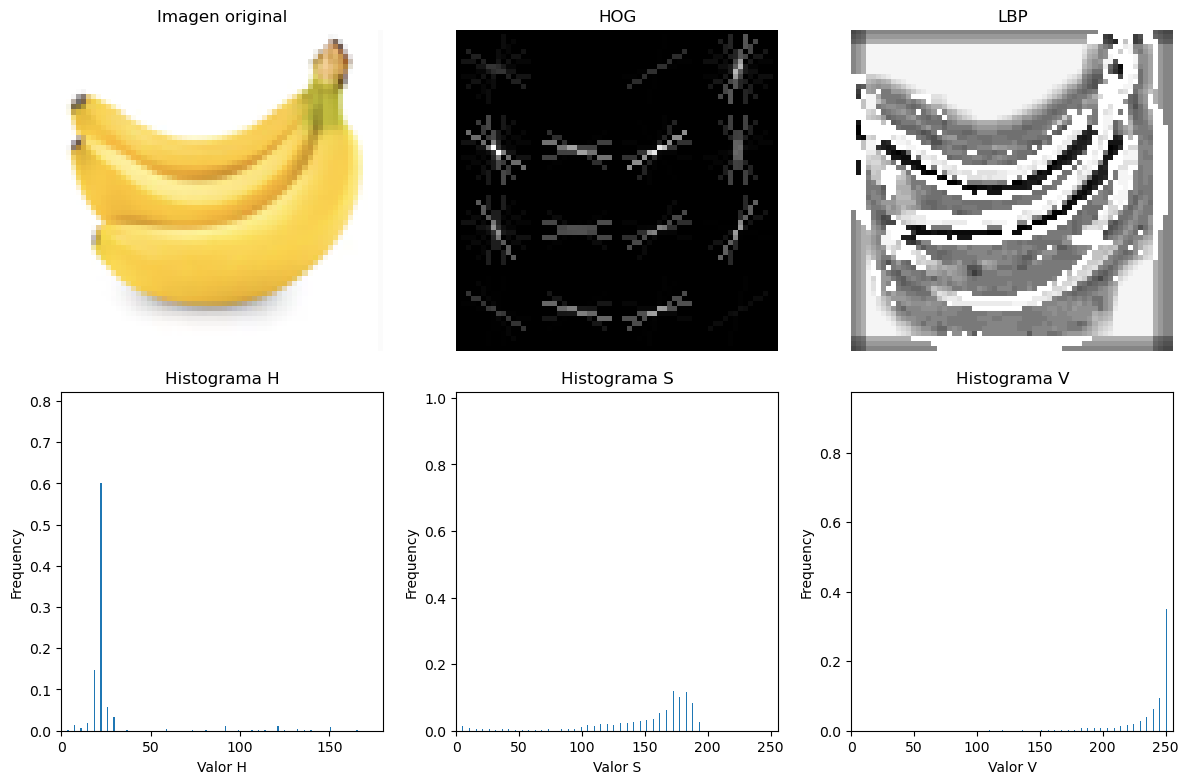

In [15]:
# Banana fresca
img = read_image(DB_PATH / "fresh_banana/Screen Shot 2018-06-12 at 9.48.39 PM.png")

# Habilitar la graficación del HOG
visualize_features(img, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

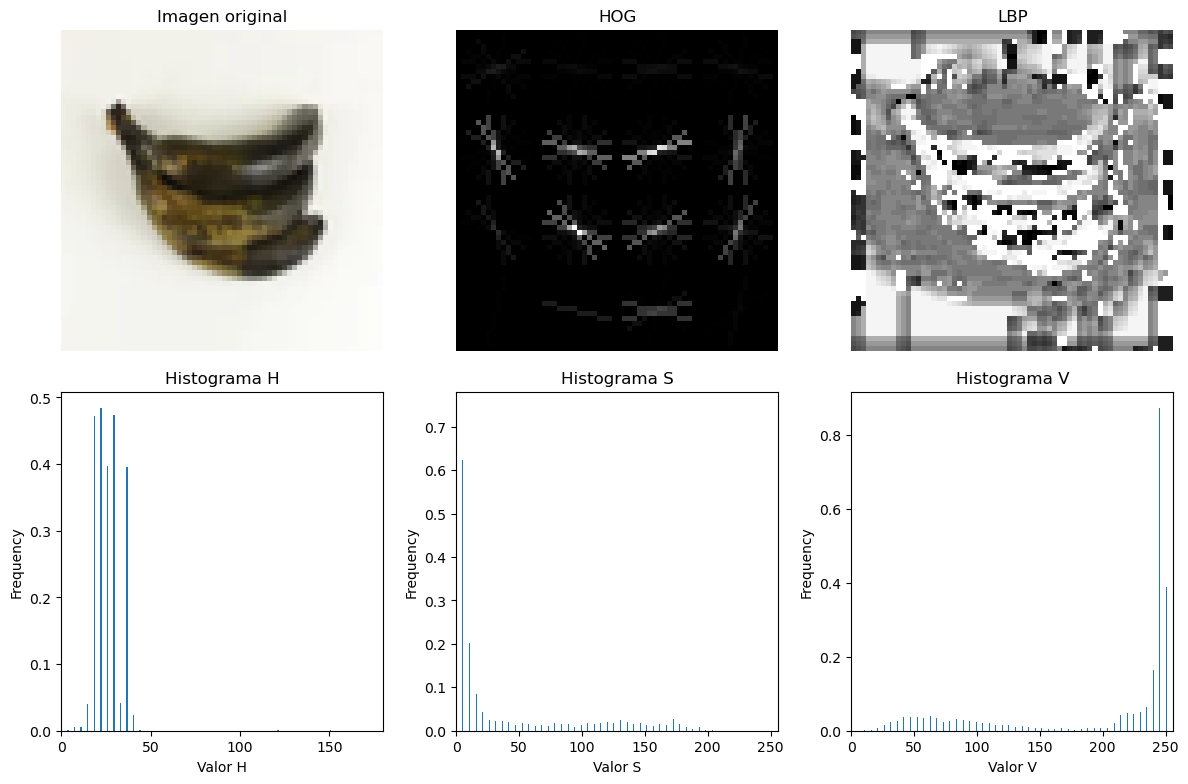

In [16]:
# Banana pútrida
img = read_image(DB_PATH / "stale_banana/Screen Shot 2018-06-12 at 8.58.49 PM.png")

# Habilitar la graficación del HOG
visualize_features(img, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

## Conclusiones
1. La característica de los histogramas de gradientes orientados (HOG) resultó útil para hallar las formas de los objetos en las imágenes, esto es especialmente significativo para la tarea de distinguir algunas frutas, por ejemplo de la forma elongada de una banana contra la forma circular de una naranja.
2. La característica de patrones binarios locales (LBP) sirvió para caracterizar las texturas presentes en las imágenes, siendo especialmente útil en las imágenes de "alta" resolución (128×128), ya que en las de baja resolución (64×64) se distorsiona demasiado.
3. Esta misma característica además permite visualizar las frutas, ya que algo tienen en común los fondos y es que son relativamente uniformes en textura, a diferencia de las frutas.
4. Mediante el análisis de histogramas de las componentes en el espacio Hue-Saturation-Value (HSV) se obtuvieron características adicionales que permiten aprovechar la diferencia en matiz, saturación y luminosidad de las imágenes, las cuales a simple vista otorgan información valiosa para la tarea de clasificación.